# Classification

In the previous [notebook](../2/End_to_end_machine_learning_project.ipynb), we worked on an end-to-end problem and used a housing dataset to predict a median house value. This was a regression problem as we were predicting a continous value. We used Linear Regression, Decision Tree, Random Forest and Support Vector Machine (We will cover all of these in next few chapters, the aim of previous notebook was to get sense of whole process).

This notebook is inspired by chapter 3 of the excellent book - [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) by Aurélien Géron. In this notebook, we will explore classification problems, where we predict which class does an instance belong to. We will MNIST dataset of 70,000 images of digits written by high-school students and employees of US Census Bureau. Each image is labelled with a digit it represents. `Scikit-Learn` let us download popular datasets. MNIST is one of them.


## Download the data.


In [73]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Each `Scikit-Learn` dataset will come in this standard dictionary structure. 
-  'data' represents the key containing an array with one row per instance and one column per feature.
- 'target' represents the key containing an array with labels.
- 'DESCR' represents the key for full description of the dataset.
-  'details' represents the key for more metadata from OpenML
For exploring more of these keys, go to [sklearn.datasets.fetch_openml](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html#sklearn.datasets.fetch_openml)

Let's get our *X* and *y*.

In [74]:
X, y = mnist['data'], mnist['target']
print("X.shape :", X.shape)
print("y.shape :", y.shape)

X.shape : (70000, 784)
y.shape : (70000,)


Each image is actually a 28 x 28 pixel image. Therefore the data has 28 x 28 = 784 features. In other words, each pixel is represented as a feature. Let's take a look at one of the images. We will use `matplotlib`'s `imshow()` function.

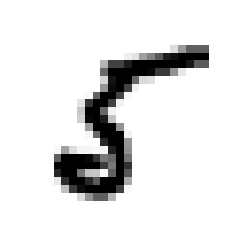

In [75]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random

index = random.randint(0, 70000)
some_digit = X[index]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()


It looks like 1, let's see what label say.

In [76]:
y[index]

'5'

It is indeed 1, the labels are string, so let's change them to actual numbers.

In [77]:
import numpy as np

y = y.astype(np.uint8)

Let's plot some more digits

In [78]:
def plot_digits_square(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

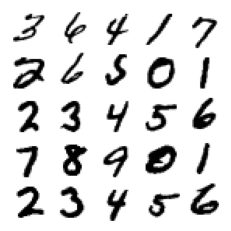

In [79]:
plt.figure(figsize=(4, 4))
example_images = X[-25:]
plot_digits_square(example_images, images_per_row=5)


## Train Test Split

Before continuing, let's do train-test split of the data. MNIST dataset is already split into training and test data. First 60,000 images are training and rest 10,000 images are test. The data is already shuffled for us.

In [80]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

For simplicity, let's first create a binary classifier, and try to identify only one digit for e.g. the number 5. Essentially we are build a 5-detector, which will classify the digits as either 5 or not 5.  The target vector will be 

In [81]:
y_train_5 = (y_train == 5) #assigns true for all 5, false otherwise
y_test_5 = (y_test == 5)

Now, let's pick a classifier and train it. We will choose *Stochastic Gradient Descent (SGD)* as our first classifier using `SGDClassifier` of Scikit-Learn. This classifier has the advantage of handling very large dataset efficiently. One of the reasons for this is because it deals with one instance at a time. This also makes it suitable for online learning. The `SGDClassifier` relies on randomnness during training hence *Stochastic*.

In [82]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Let's see if how well it predicts. Let's first try for the `1` we had initially used.

In [83]:
sgd_classifier.predict([some_digit])

array([ True])

It is indeed not a `5`. Let's evaluate the entire model's performance. 

## Performance Measures for Classification.

In this section, we will see how to measure performance of the Classification models. There are various nuances involved. Let's see if accuracy is a good measure or not.

### Measuring accuracy using cross-validation.

We usually use `cross_val_score()` to do off-the-shelf cross-validation. However, sometimes we want to have more control over this process. In that case we use `StratifiedKFold`. It performs stratified sampling to produce folds which contain a representative ratio of each class. At each iteration, we get the new test and train data, we clone the model, and train it fresh. After that we make prediction on test fold. This way, a model never sees the test data on which we predict.

In [84]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# We will have 3 folds
skfolds = StratifiedKFold(n_splits=3, shuffle=False)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_classifier)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print("Accuracy of the fold: ", n_correct/len(y_pred))

Accuracy of the fold:  0.95035
Accuracy of the fold:  0.96035
Accuracy of the fold:  0.9604


Wow, the performance looks good, *but is it?*. Imagine you have a dataset of emails which has either legitimate emails or spam emails. There are say 95% legitimate emails and 5% spam emails. Let's say you want to build a classifier to classify legitimate and spam emails. If for every prediction you say that email is legitimate, you will be right 95% of the time. 

Let's do the same with above case, let's just always predict that value is not 5. You can imagine what happens!

In [85]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [86]:
from sklearn.model_selection import cross_val_score

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

As expected, we will always get around 90% accuracy! This is because we have 10% images as not 5. So if we always guess image is not 5, we will be right 90% of the time.


Clearly, the example above describe why accuracy is a bad performance measure for classifiers, especially when datasets are skewed. Let's try another performance measurement technique.

### Confusion Matrix

A much better way to evaluate performance of classification task is to look at *Confusion Matrix*. The ideas is to count the number of times instances of class A are classified as instances of Class B.

To compute confusion matrix, we need to have set of predictions so that those can be compared to the actual target. Let's use `cross_val_predict` to get those. Just like `cross_val_score` function, `cross_val_predict` performs K-fold cross-validation but instead of returning the evaluation scores, it returns the predictions made on each test fold.  This means that we get a clean prediction of each instance in the training set (clean because the model used for a certain prediction has never seen that prediction before, this is done by creating a new model for each set of folds, as we have done above using `StratifiedKFold`.

In [87]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)

Now, let's get the confusion matrix using the `confusion_matrix` function.

In [88]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

![alt tag](util/confusion_matrix.png)

<div class="alert alert-block alert-success">
Each row in a confusion matrix represents an <i>actual class</i> while each column represents a <i>predicted class </i>.  The first row of matrix represents the non-5 images (the <i>negative classs</i>). 53,892 of them were correctly classified as non-5 images (They are called <i>true negatives</i>), while the remaining 687 were wrongly classified as 5s (<i>false positives</i>). The second row represents the 5-image (the <i>positive class</i>).  The 1891 were classified as non-5s (<i>false negatives</i>) and while the remaining 3530 were correctly classified as 5s (<i>true positives</i>). A perfect classifier will only have true positives and true negatives, therefore it will *only* have non-zero values across the main diagonal.
</div>

<div class="alert alert-block alert-danger">
Remember! The convention to represent the various values may vary. The current convention is from what `Scikit-Learn` represents. In [wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix) entry for confusion matrix, the true-positives are in first row, first column. Here we have it opposite.
</div>

`scikit-learn` also let's you plot the confusion matrix. Let's try that.

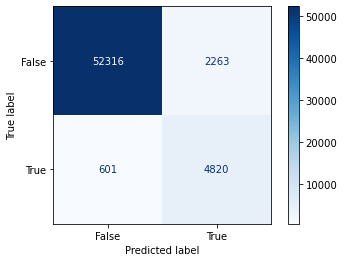

In [89]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(sgd_classifier, X_train, y_train_5, values_format="d", cmap=plt.cm.Blues)

We can also give some labels

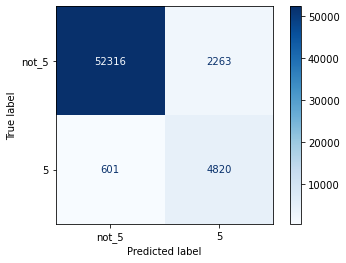

In [90]:
plot_confusion_matrix(sgd_classifier, X_train, y_train_5, 
                      values_format="d", cmap=plt.cm.Blues, display_labels=['not_5', '5'])

Let's assume we have the perfect classifier, in that case the confusion matrix will look like this.

In [91]:
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

The confusion matrix gives a good amount of detail, but sometimes we may prefer a more concise matrix. An interesting one is to look at the accuracy of the positive predictions, this is called ***precision*** of the classifier.

$$precision = \frac{TP}{TP+FP}$$

*TP* is true positives and *FP* are the number of false positives.

<div class="alert alert-block alert-info">
    Precision looks at the accuracy of of the positive predictions. What proportions of the positive indentifcations were actually correct? It looks at the vertical row of the confusion matrix.
</div>

A trivial way to get 100% perfect *precision* is to make only one prediction and get it right. (1+0/1 = 100%). However, that will not be very useful, since the classifier will ignore all but one positive instance. So *precision* is typically used along with *recall* also called *sensivity* or the *True Positive Rate (TPR)*. This is the ratio of positive instances that are correctly detected by the classifier.

$$recall = \frac{TP}{TP+FN}$$

*FN* is the number of false negatives. 

<div class="alert alert-block alert-info">
    Recall tells us what proportions of the actual positives was identified correctly. It looks at the horizontal row of the confusion matrix.
</div>

`Scikit-Learn` provides convinient ways to directly calculate precisiona and recall.

In [92]:
from sklearn.metrics import precision_score, recall_score

print("Precision score:", precision_score(y_train_5, y_train_pred))
print("Racall score:", recall_score(y_train_5, y_train_pred))

Precision score: 0.8370879772350012
Racall score: 0.6511713705958311


So what this numbers tells us is that when our classifier classifies an image as 5, it is correct 83% of the time. Moreover, it is only detecting 65% of the 5 values.

This tension of precision and recall can be combined into a single metric *$F_1 score$* which takes into account both *precision* and *recall*. The *$F_1 score$* is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

$$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP + \frac{FN+FP}{2}}$$

In [93]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

The $F_1 score$ favors the classifier which have similar precision and recall. However, it might not be what application wants. Let's take an example. Imagine we are building a youtube like service for the kids. We have a classifier which tells us whether the video being uploaded is safe for the kids or not. In this case, we definitely want a classfier that keeps safe videos (i.e. high precision) but it's okay to reject many good videos (i.e. low recall). It would be much better than a system with higher recall and low precision (where there is a chance that some videos might be bad). 

As an another example, if we are building a system for shoplifting in survellience images. It will be fine if your system has lower precision (say 30%) but as long as it has higher recalls (say 90%). Security guards might have false alerts but almost all shoplifters will be caught.

Unfortunately, we can't have it both ways. Increasing recall decreases precision and vice versa. This is called *precision/recall trade-off*.

## Precision Recall Trade off

For each new instance, our system computes a score based on *decision function*. If the score is higher than a *threshold*, the system assigns it othe positive class; otherwise, it is assigned to negative class. In the below image, there are 30 predictions made by an email classification model. Those to the right of the threshold are classified as *spam* and those to the left are classified as *not spam*. 

![alt tag](util/classification1.png)

Image source : [Google Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)

Let's first create the *confusion matrix* for it. 

|   |   |
|:---:|:---:|
|True Negatives (TN) 17 |  False Positives (FP) 2 |
|False Negatives (FN) 3   | True Positives (TP) 8 |

In this case, precision will be **percentage of emails we flagged as spam**  that were correctly classified.

$$Precision =  \frac{TP}{TP + FP} = \frac{8}{8+2} = 0.8$$

Recall will be the percentage of **actual spam emails** that were correctly classified

$$Recall =  \frac{TP}{TP + FN} = \frac{8}{8+3} = 0.73$$

We have 8 emails classified as spam, which are actually spam (TP = 8). We have 2 emails classified as spam but they are not spam (FP = 2). We have 17 emails classified as not spam, which are actually not spam (TN = 17). Finally we have emails which are falsely classified as not spam, which are actually spam (FN = 3). Therefore for precision we have identified 8 emails as spam correctly out of total 10 emails we classified as spam therefore 0.8. Similarly, out of total 11 spam emails, we identified 8 emails as spam, hence 0.73.

Now, let's move this classification threshold to right. 

![alt tag](util/classification2.png)

Let's see the *Confusion Matrix* for this case.


|   |   |
|:---:|:---:|
|True Negatives (TN) 18 |  False Positives (FP) 1 |
|False Negatives (FN) 4   | True Positives (TP) 7 |

In this case, the number of false positives decreases, but we also see rise in false negative. Therefore, precision increases but recall decreases.

Remember, precision is the **percentage of emails we flagged as spam**  that were correctly classified.

$$Precision =  \frac{TP}{TP + FP} = \frac{7}{7+1} = 0.88$$

Recall is the percentage of **actual spam emails** that were correctly classified

$$Recall =  \frac{TP}{TP + FN} = \frac{7}{7+4} = 0.64$$

In the last case, let's move classification threshold to the left, it will result in decrease of precision and increase of recall.

![alt tag](util/classification3.png)


|   |   |
|:---:|:---:|
|True Negatives (TN) 16 |  False Positives (FP) 3 |
|False Negatives (FN) 2   | True Positives (TP) 9 |

$$Precision =  \frac{TP}{TP + FP} = \frac{9}{9+3} = 0.75$$

$$Recall =  \frac{TP}{TP + FN} = \frac{9}{9+2} = 0.82$$

`scikit-learn` doesn't let you set the threshold directly, but we get access to decision scores, which we can use to make prediction. This can be done using `decision_function` instead of `predict` method. `decision_function` will give you score for each instance, and then we can use any threshold to make predictions. Let's see this in code.

In [94]:
y_scores = sgd_classifier.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[7908.98954755]
[ True]


`SGDClassifier` by default uses 0 as threshold, therefore, in this case, result is same as predict function i.e. False.  We can change the threshold to any value and we will see the precision-recall tradeoff.

How do we decide what is the good value for threshold. This can be done by using `decision_function` as method in `cross_val_predict`. Let's try that.

In [95]:
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method="decision_function")

We just calculated scores for each instance. Now we can use these scores in `precision_recall_curve` to compute precision and recall for all possible threshold. Let's do that.  


In [96]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Lastly we can use `matplotlib` to plot precision and recall as function of various threshold values. 

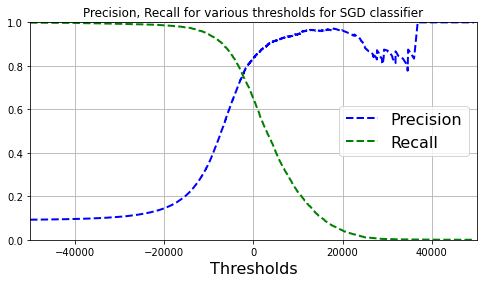

In [97]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, title):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Thresholds", fontsize=16)
    plt.title(title)
    plt.axis([-50000, 50000, 0, 1])


plt.figure(figsize=(8,4))
plt.grid(True)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, 
                                   "Precision, Recall for various thresholds for SGD classifier")

<div class="alert alert-block alert-warning">
When threshold is increased precision curve looks bumpier, because precision may sometimes go down when threshold is raised, although it usually goes up. On the other hand, Recall will always decrease or likely stays the same. The number of true positives may decrease or stay the same and will the cause the number of false negatives to increase or stay the same. 
</div>


Another way to understand the precision-recall tradeoff is to plot precision directly against recall.

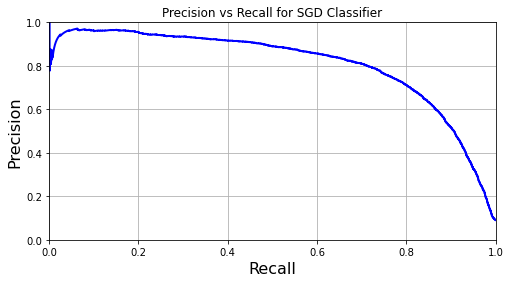

In [98]:
def plot_precision_vs_recall(precisions, recalls, title):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.title(title)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8,4))
plot_precision_vs_recall(precisions, recalls, "Precision vs Recall for SGD Classifier")

We can see that precision starts falling around 75% recall.  It is usually there we want to select a precision/recall trade-off. However ofcourse, as discussed above choice depends on project requirements. Using these two plots we can decide what threshold we need to choose. For e.g. let's say we go with 90% precision, in that case, the first plot will tell us the right threshold to use. In this case it is ~4000. Let's see how we use that in code.

In [99]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

Now, we can modify our labels this way.

In [100]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print("Precision: ", precision_score(y_train_5, y_train_pred_90))
print("Recall: ", recall_score(y_train_5, y_train_pred_90))

Precision:  0.9000345901072293
Recall:  0.4799852425751706


## The ROC curve

The *Receiver Operating Characteristic (ROC)* curve is another metric to measure the performance of binary classifier. It is a graph which shows the performance of classification model at all classification thresholds. The curve plots two parameters.

- True Positive Rate (TPR) which is synonym for recall.
$$TPR = \frac{TP}{TP+FN}$$

- False Positive Rate (FPR). It is the ratio of negative instances that were incorrectly classified as positive. It is 1 - the *True Negative Rate(TNR)* which is ratio of negative instances that were correctly classified as negative. The TNR is also called *Specificity*. Hence the ROC curve plots *sensitivity* (recall) vs 1 - *specificity*.  
$$TPR = \frac{FP}{FP+TN}$$

In other words, an ROC curve plots TPR vs FPR at various classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both false positives and true positives. 

`Scikit-Learn` provides `roc_curve` to compute TPR, FPR at various threshold values.


In [101]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Now, let's plot the curve. 

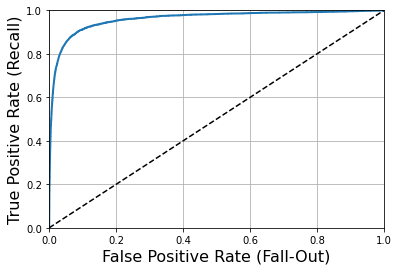

<Figure size 576x432 with 0 Axes>

In [102]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])                              
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            
    

plot_roc_curve(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.show()

We can see that the higher the recall (TPR), the more false positives (FPR) the classifier produces. The straight dotted line represents when we are just randomly assigining a class. The model is better if the curve line representing the model is farther from this straight dotted line.

### Area under the ROC curve (AUC)

AUC stands for "Area under the ROC curve". AUC measures the entire two-dimensional area underneath the ROC curve. If we integrated curve of FPR vs TPR at various thresholds ranging from (0,0) to (1,1), we will get the area under this curve.
AUC lets us know the aggregate performance of the model across all possible classification threshold.One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example. The perfect classifier will have area under the curve as 1, while a purely random classifier will have 0.5.

In [103]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

<div class="alert alert-block alert-warning">
This looks great but we need to remember our positive class (5) is rare. As a rule of thumb, when positive class is rare or we care a lot about false positive than the false negative, we should prefer Precision-Recall curve over ROC curve. The ROC curve and AUC here gives us that model is really good, this is mostly because there are few positives (5s) compared to the negatives (non-5s).Looking at Precision-Recall curve, we can see that there is a room for improvement. The curve should be closer to top-right corner.
 </div>
 
Let's try a hopefully better classifier `RandomForestClassifier`. We will go in detail in later chapter on how this works, here we will directly use and how it does on the various metrics we explored. Also to note that `RandomForestClassifier` doesn't have `decision_function` instead it has `predict_proba` function. `Scikit-Learn` classifiers usually have one or the other or both. The `predict_proba` gives an array containing a row per instance and column per class, each containing probability that the given instance belongs to a given class.  

In [104]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

let's explore `y_probas_forest`.

In [105]:
print(y_probas_forest[0], y_train_5[0])

[0.11 0.89] True


This basically tells us that first instance has 0.89 probability of being a 5, and 0.11 probability of not being a 5. Since `roc_curve` takes the labels and scores, but instead of scores we can give it positive class's probability.

In [106]:
y_scores_forest = y_probas_forest[:, 1] # second column represents positive class's proba
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Let's plot the ROC curve of this `RandomForestClassifier` along with ROC curve of `SGDClassifier` we had before. This will let us compare the two models easily.

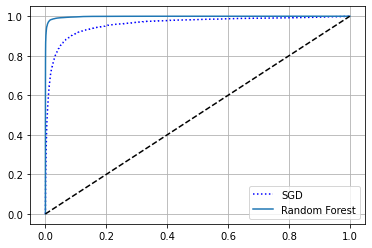

<Figure size 576x432 with 0 Axes>

In [107]:
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc="lower right")
plt.grid(True)
plt.figure(figsize=(8, 6))
plt.show()

We can clearly see, the Random forest model is way better. Let's also calculate AUC

In [108]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Now, we are talking!! It is much better AUC. Let's also see precision and recall for this model and compare it with SGD

In [109]:
from sklearn.metrics import precision_recall_curve
precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(y_train_5, y_scores_forest)

<Figure size 576x288 with 0 Axes>

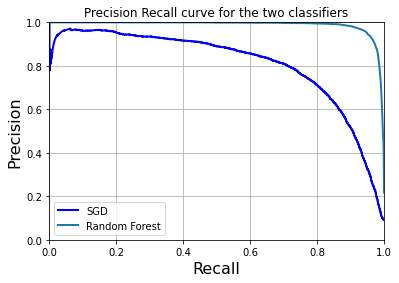

<Figure size 576x288 with 0 Axes>

In [113]:
plt.plot(recalls, precisions, "b-", linewidth=2, label="SGD")
plt.plot(recalls_rf, precisions_rf, linewidth=2, label="Random Forest")
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.title("Precision Recall curve for the two classifiers")
plt.legend(loc="lower left")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.figure(figsize=(8,4))

RandomForest is much farther to right corner. It has high precision and high recall than SGD classifier. Let's calculate recall at 0.99 precision

In [115]:
threshold_99_precision = thresholds_rf[np.argmax(precisions_rf >= 0.99)]
threshold_99_precision

0.51

In [118]:
y_train_pred_99 = (y_scores_forest >= threshold_99_precision)
print("Precision: ", precision_score(y_train_5, y_train_pred_99))
print("Recall: ", recall_score(y_train_5, y_train_pred_99))

Precision:  0.9905083315756169
Recall:  0.8662608374838591


At 99% precision, we have 86% recall! This is a better model in every way!

## MultiClass Classification

So far we have seen classifiers for two classes (5 or not 5) called binary classifier, now let's focus on classifiers which can distinguish or classify more than 2 classes.  The problem we started with of classifying MNIST images from numbers 0-9 is a multiclass classification problem, here number of classes are 10. 

Some algorithms e.g. Logistic Regression, Random Forest Classifiers, and Naive Bayes Classifiers are capable of handling multiple classes natively. Others such as Stochastic Gradient Descent (SGD, we just saw) and Support Vector Machines are strictly binary classifiers. 

There are some strategies where we can perform multiclass classification using multiple binary classification.

*One-versus-the-rest (OvR)* or *One-versus-All* classifier: In this approach, we create a classifier for each class (just like we created a classifier for just 5, i.e. just like 5-detector, we can build 0-detector, 1-detector, 2-detector and so on..). Then when we want to classify a new instance say a new image of a number, we get the decision score from each classifier and select the classifier which has the highest score. 

*One-versus-One (OvO)* Classifier: In this approach, we build a classifier for each pair of classes. e.g. we build one classifier to distinguish between 0s and 1s, then we build one for 1s and 2s, then 2s and 3s and so on. If there are *N* classes we will have *N x (N-1) / 2* classifiers. For our MNIST problem, we will have to train 45 binary classifiers. For a new instance of the image, we will have to run through 45 classifiers, and then see which class wins the most duels.


Algorithms like Support Vector Machines scale very poorly with size of the dataset. For such algorithms, OvO is preferred approach as it is faster to train many classifiers on small training sets than to train few classifiers on large training set. For most binary classification algorithms, we prefer OvR.

`Scikit-Learn` lets you us a binary classification algorithm for a multiclass classification task and then it automatically runs OvR or OvO, depending on algorithm. Let's build a Support Vector Machine classifier (which again we will cover later)



In [119]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) #all classes not just 5
svm_clf.predict([some_digit])


array([5], dtype=uint8)

Our `some_digit` is indeed 5. Let's see what scores did we have for this instance for all the classes.

In [120]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 6.23025333,  6.8468444 ,  3.7687758 ,  2.7677844 , -0.30115588,
         9.31599136,  4.81383826,  0.70212011,  8.30755227,  1.70392242]])

In [121]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [122]:
svm_clf.classes_[np.argmax(some_digit_scores)]

5

We can map them to individual classes by using `classes_` attribute. Remember that order of attributes in `classes_` may not always be ordered. Although In this case, it is ordered. See 5 wins here.We can also choose the strategy on our own by using `OneVsOneClassifier` or `OneVsRestClassifier`. For example we can use the same 

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])
